<h1>Semi-Supervised Learning</h1>
Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training. Semi-supervised learning falls between unsupervised learning and supervised learning.

Source: https://en.wikipedia.org/wiki/Semi-supervised_learning


### Content

1. [Introduction](#Introduction)
2. [Functions Used](#Functions-Used)
3. [Dataset Used](#Dataset-Used)
4. [KMeans Clustering](#KMeans-Clustering)
5. [Manual Labeling](#Manual-Labeling)
 1. [Manual labeling](#Manual-Labeling)
 2. [Label propagation](#Label-propagation)
 3. [Clipping data points](#Clipping-data-points)
 4. [Result](#Manual-Clustering-Result)
6. [Auto Labeling](#Auto-Labeling)
 1. [Plot pairwise distance](#Auto-Labeling)
 2. [Auto label Grouping](#Auto-label-grouping)
 3. [Label Propagation](#Label-propagation)
 4. [Clipping data points](#Clipping-data-points)
 5. [Result](#Auto-Labeling-Result)
7. [Insights](#Insights)

## Introduction
<p>In the world of Data Science, data is divided into two types:- raw/unstructured/unsupervised data and labeled/structured/supervised data. I can assume that we are aware of supervised and unsupervised data. </p>
<p>As we all know the larger part of the data is unsupervised, and knowing the fact that it is not easy to deal with it but it is also important to find valuable insights from unsupervised data. There are many ways available to understand unsupervised data, but in this notebook we will try use semi-supervised learning to understand the unsupervised data.</p>
<p><b>Semi-supervised learning</b> is the combination of supervised and unsupervised learning. So, as the definition says "<b><em>Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training</em></b>", we are in need of small amount of labeled data to play with it. Lets see what we can do with the data.</p>

In [1]:
#Libraries used
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

### Functions Used 
<p>All the functions are easy to understand and we will also see the uses of these function in further steps</p>

In [2]:
def group_cluster_labels(cluster_labels, number_of_data_points, new_labels):
    '''
        Recreation/re-assigning of labels to cluster labels or 
        grouping up the different cluster by there visual appearance
        
        IMPORTANT PART FOR SEMI-SUPERVISED LEARNING
        
        @cluster_labels: kmeans.labels_ | labels generated from clustering algorithms
        @number_of_data_points: length of your train data to create empty array of same size
        @new_labels: new labels to group the cluster labels. new_labels and cluster_labels must be of same size
        
        return: updated labels
    '''
    updated_labels = np.empty(number_of_data_points, dtype=np.int32)
    for i in range(k):
        updated_labels[kmeans.labels_==i] = new_labels[i]
    return updated_labels

def display_cluster_centers(cluster_center_vector, size=[8,8]):
    '''
        Display all the cluster center images to find the groups.
        
        @cluster_center_vector: flatten cluster center image array to display. 
    '''
    r,c = np.ceil(np.sqrt(len(cluster_center_vector))), np.ceil(np.sqrt(len(cluster_center_vector))) 
    plt.figure(figsize=(7,7))
    for idx, dig in enumerate(cluster_center_vector):
        plt.subplot(r, c, idx+1)
        plt.imshow(dig.reshape(size), cmap="gray")
        plt.axis('off')
        
def automatic_label_grouping(pair_dist, n_clusters, threshold=30):
    '''
        Automatic grouping of similar clusters based on the centers. 
        
        @pair_dist: pair distances of cluster center data points
        @n_clusters: number of clusters
        @threshold: threshold is minimum value of distance to be used to group clusters
        
        return: labels of grouped clusters
    '''
    temp_labels = [i for i in range(n_clusters)]
    for i in range(len(pair_dist)):
        for j in range(i+1, len(pair_dist)):
            if pair_dist[i, j] < threshold:
                temp_labels[j] = temp_labels[i]
    return temp_labels

def get_closest_data_points_to_cluster_centers(cluster_distance, cluster_labels, x_train, y_train, closest_percent=70):
    '''
        This is used to find the data points closest to the cluster center by setting up the threshold as percentage.
        Can to used to find the outliers
        
        @cluster_distance: distances from cluster centers generated from clustering (cluster_distance = kmeans.fit_transform)
        @cluster_labels: labels generated from clustering
        @x_train: dependent variable or x training data points matrix
        @y_train: Can be cluster labels or manually grouped labels or true labels
        @closest_percent: percentage to get the data point to cluster center
        
        return: top n percent x_train, y_train, group_indexes(index values of data points)
    '''
    updated_cluster_distance = cluster_distance[np.arange(len(x_train)), cluster_labels]
    for i in range(k):
        _cluster_labels = (cluster_labels == i)
        _cluster_dist = updated_cluster_distance[_cluster_labels]
        cutoff_distance = np.percentile(_cluster_dist, closest_percent)
        above_cutoff = (updated_cluster_distance > cutoff_distance)
        updated_cluster_distance[_cluster_labels & above_cutoff] = -1

    group_indexes = (updated_cluster_distance != -1)
    group_indexes = [key for key, val in enumerate(group_indexes) if val]
    return x_train[group_indexes], y_train[group_indexes], group_indexes

def display_paired_distances(cluster_center_data_points):
    '''
        Display the heatmap of paired distances
        
        @cluster_center_data_points: feature vectors
        return: paired distances
    '''
    pair_dist = pairwise_distances(cluster_center_data_points)
    plt.figure(figsize=(15,10))
    _ = sns.heatmap(pair_dist, cmap="gray")
    return pair_dist


### Dataset Used
We can use any kind of data for understanding the algorithm. But, for better visualization purpose we are going to use MNIST hand written data set of feature size 64.

In [3]:
X, y = load_digits(return_X_y=True)

### KMeans Clustering
<p>KMeans is the clusterig technique whereas, Clustering is a technique to club the similar featured data in same group/cluster. Basic idea behind clustering in our context is: We are assuming that the MNIST dataset we are having with us is unsupervised/unstructure. Clustering will help us to find the similarity among the different data points/images and try to make small groups of them known as clusters.</p>

Working of KMeans in short: 
1. Select the number of clusters $k$ that we can think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

<h3>Create the labeled data</h3>
<p>Train the KMeans with n number of clusters and find the images near to the cluster center, those images we will going to use for labeling.</p>
<ul>
    <li><strong>X_cluster_dist</strong> is list of distances from the cluster centers to the data points in that cluster</li>
    <li><strong>X_center_digits</strong> is the list of images near to the cluster center, hence the shape is (50, 64)</li>
</ul>

In [4]:
k = 50
kmeans = KMeans(n_clusters=k)
X_cluster_dist = kmeans.fit_transform(X)
center_digit_idx = np.argmin(X_cluster_dist, axis=0)
X_center_digits = X[center_digit_idx]

# Manual Labeling
In this step we are going to label the images near to cluster with manual effort, which are being treated as the small amount of labeled data needed for semi-supervised data

<strong>display_cluster_centers</strong> is the function to display the cluster center images, so we can examine them and label them correctly. Here we are not concern about the well defined classes or the exact label value. We can say that we are just going to map the similar looking images a single label.

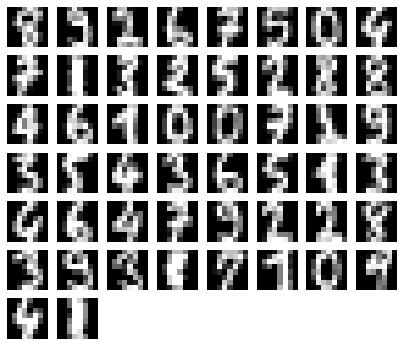

In [5]:
display_cluster_centers(X_center_digits)

Here, we need to assign the same class to the visually similar images. For better visualization we are going to label correctly. Again in most of the cases we might not aware of the images or the data so, it is very hard to assign correct label.
End goal is to assign the unique label to similar looking images or the data which shows the same properties

In [17]:
manual_y_group_digits = [8,9,2,6,7,5,0,4
                       ,7,1,3,2,5,2,8,8
                       ,4,6,1,0,0,7,1,9
                       ,3,5,4,3,6,5,1,3
                       ,4,6,4,7,9,2,2,8
                       ,3,9,3,1,7,1,0,7
                       ,4,1]

### Label propagation
<p>It is a fancy word I have read somewhere so I have used it here. Basically we are just going to replace the labels generated by kmeans with the labels which we have manually created. </p>
Label propagation: Propagating the labels to all other instances

In [18]:
manual_y_grouped_labels = group_cluster_labels(kmeans.labels_, len(X), manual_y_group_digits)

### Clipping data points
In this we are going to find the images or data points closest to the center of cluster by setting up the threshold. Threshold is treated as the percentage, means we are going to find the images under (0-100 any value) percent resulted images near to cluster center.

In [19]:
manual_train_x, manual_train_y, manual_train_indexes = get_closest_data_points_to_cluster_centers(X_cluster_dist,
                                                                                                   kmeans.labels_,
                                                                                                   X,
                                                                                                   manual_y_grouped_labels,
                                                                                                   closest_percent=70)

Reading 10 images from every cluster for visual representation.

In [22]:
manual_images_x=[]
for v in range(0,10):
    manual_images_x+=list(manual_train_x[manual_train_y==v][:10])

### Manual Clustering Result
Every row is the different class and each row is having 5 images of same cluster.
We can see that most of the classes are able to return impressive result.
<p>In total there are 10 classes having 5 images to display for each of it</p>
<p>In this usecase, it is pretty simple to give correct classes to data points or images but, as in real usecases where we might face large amount of dataset with 100s of clusters with very little visual representation. This process will be head hitting. We can have a look on auto labeling.</p>

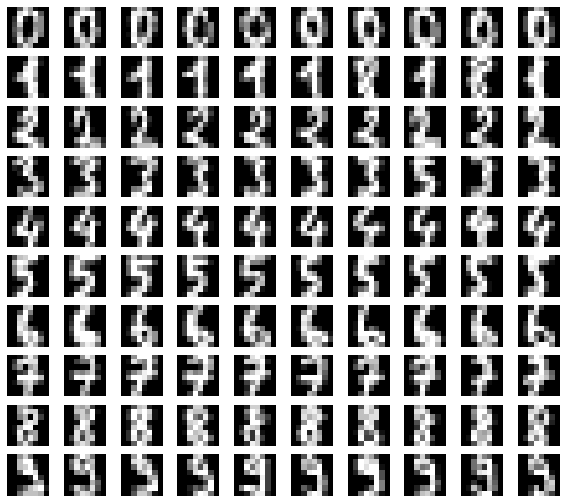

In [23]:
inc = 1
plt.figure(figsize=(10,9))
for inc, img in enumerate(manual_images_x):
    plt.subplot(10,10,inc+1)
    plt.imshow(img.reshape([8,8]), cmap="gray")
    plt.axis("off")
    inc+=1
#     plt.show()

# Auto Labeling
<p>In the above step, we have done labeling manually but in this step we will try to label the images automatically or using a simple algorithm. </p>
<p>If we will see the problem statement again. It says that we need to club the similar looking images in single cluster, so what is the intuition behind it?</p>
<p>Lets consider the fact that images in same cluster have the same visual representation, which means that algorithmically they have very little difference between there structural and visual features. Now, we can try out finding the distances among themselves(cluster center images). </p>
<p>If cluster "1" is having very little distance with cluster "34". They both can be clubbed into single cluster and proper name can be given to them. To solve this we are going to use pairwise distance matrix which uses euclidean distance. "Darker the blick lesser the distance"</p>


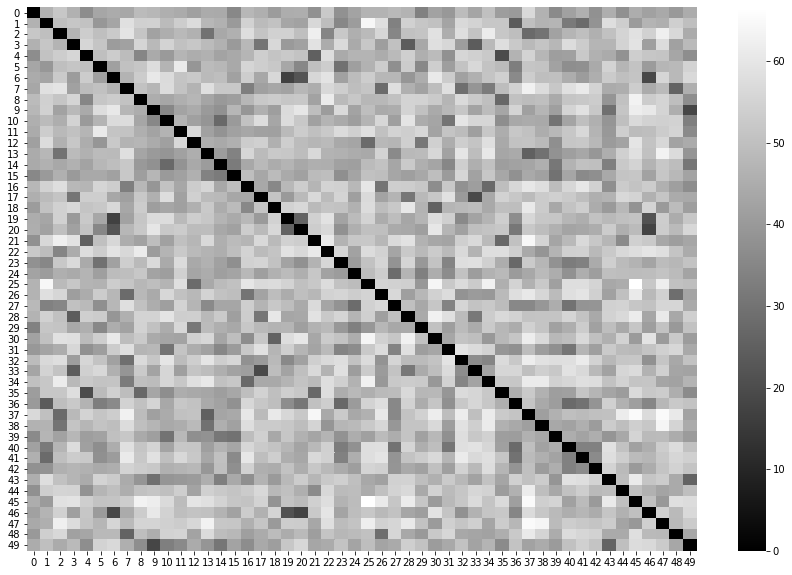

In [24]:
dist_pair = display_paired_distances(X_center_digits)

### Auto label grouping
<p>After creating pairwise distance matrix. We need to re-label the cluster labels, so this will help to create new label matrix which will be used for re-labeling.</p>
<p>The cluster label having the distance with other labels are less than the threshold is clubbed with the same label.</p>

In [25]:
auto_labels = automatic_label_grouping(dist_pair, k, threshold=30)

### Label propagation same as the Manual label propagation

In [26]:
auto_train_labels = group_cluster_labels(kmeans.labels_, len(X), auto_labels)

### Auto label - Clipping data points
It is also similar to Manual labeling clipping data points

In [27]:
auto_train_x, auto_train_y, auto_train_indexes = get_closest_data_points_to_cluster_centers(X_cluster_dist,
                                                                                           kmeans.labels_,
                                                                                           X,
                                                                                           auto_train_labels,
                                                                                           closest_percent=70)

Reading 10 images from every cluster for visual representation of auto labeling.

In [28]:
auto_images_x=[]
for v in list(set(auto_labels)):
    auto_images_x+=list(auto_train_x[auto_train_y==v][:10])

### Auto Labeling Result
<p>The result generated from auto labeling is impressive and also showing the classes or clusters more than 10. If you think that digits must be clustered in 10 clusters which is true as well but, if you ignore the fact that they have the defined number of classes then we can come to a better conclusion. </p>
<p>The data is clustered into 20+ number of clusters in this case where, if we closely monitor that the class having the visual representation value as "1" is divided into 3 or more clusters. This cannot be ignored that all three clusters of "1" is following there own feature distribution which means all the clusters of "1" are sub-divided into multiple features which is quite impressive and cannot be seen in Manual labeling.</p>
<p>By using this method for semi-supervised learning might help you to see your data differently</p>

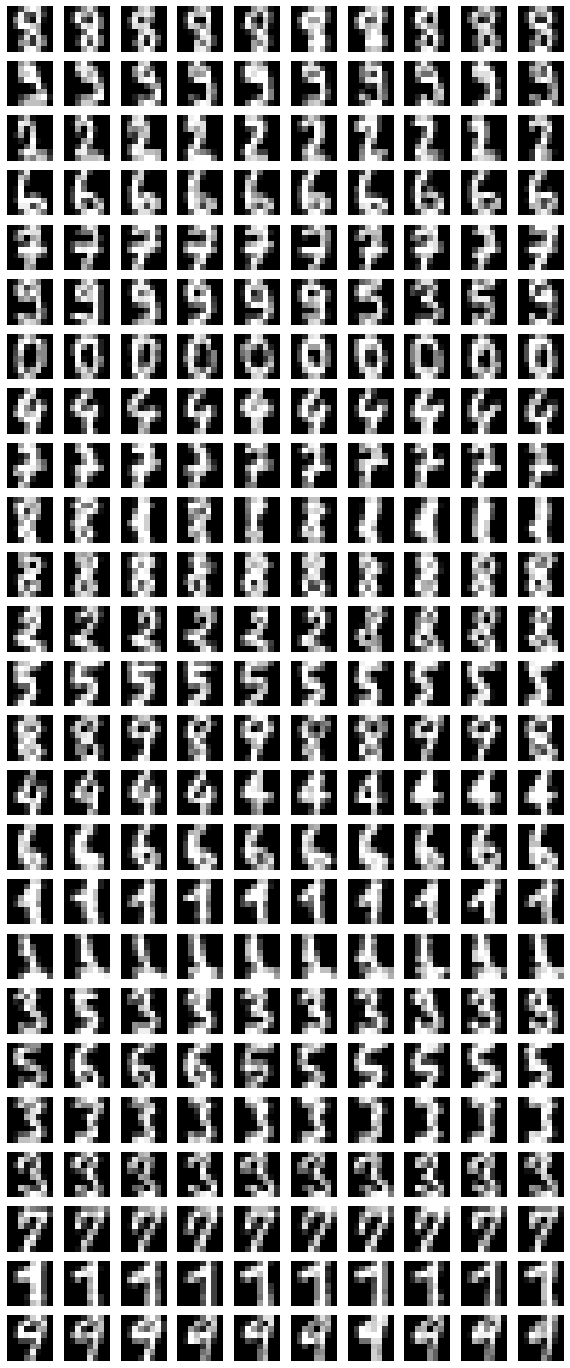

In [29]:
inc = 1
plt.figure(figsize=(10,len(auto_labels)))
for inc, img in enumerate(auto_images_x):
    plt.subplot(len(auto_labels),10,inc+1)
    plt.imshow(img.reshape([8,8]), cmap="gray")
    plt.axis("off")
    inc+=1
#     plt.show()

# Insights
* We have used the hand written digit dataset for better visualization and to keep it simple. Other datasets can also be used
* No doubt manual labeling can give desired result but, very time consuming and complex
* We can also retrain the data with classification algos after manual or auto labeling process
* Instead of doing Manual labeling in beginning step, we can label manually after auto labeling step, this will give you the quite similar result to Manual labeling but with very less effort !IMPORTANT
* Auto labeling can have multiple usecases eg: Semi-supervised learning for **Text clustering where you can replace "euclidean distance" with "cosine distance"**
* There are many data points left behind after "clipping data point" step. These excluded data points can be used to find the different trend in the data while training
